In [1]:
import patato as pat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from skimage.feature import graycomatrix, graycoprops

PIXEL_SIZE = 15

This script calculates some radiomics features. This wasn't used in the final paper, as it really just showed the same information as simpler metrics. It is provided for completeness.

In [2]:
# ROI_NAME = ("artery_", "0")
# SITE_NAME = "forearm"

ROI_NAME = ("artery_", "0")
SITE_NAME = "forearm"

In [3]:
def float_to_uint8(x):
    maxv = np.iinfo(np.uint8).max

    # Fairly liberal ranges, I haven't seen any PA images outside this range. Adjust as necessary.
    maxf = np.max(x)
    minf = np.min(x)

    y = (maxv * (x - minf) / (maxf - minf)).astype(np.uint8)
    return y


def get_artery_gcm_metrics(pa, plot=None):
    pa.set_default_recon(("Model Based", "0"))

    rec = pa.get_scan_reconstructions()
    rec.raw_data = np.array(rec.raw_data)

    # Get the x/y indices of the radial artery.
    roi = pa.get_rois()[ROI_NAME]
    xs = rec.da.coords["x"].values
    x, y = np.squeeze(roi.get_polygon().centroid.xy)
    xi, yi = [np.argmin(np.abs(xs - a)) for a in [x, y]]
    reference_sample = np.s_[
        :,
        10,
        yi - PIXEL_SIZE // 2 : yi + PIXEL_SIZE // 2,
        :,
        xi - PIXEL_SIZE // 2 : xi + PIXEL_SIZE // 2,
    ]
    r = []
    for wavelength in range(len(pa.get_wavelengths())):
        sample_s = np.s_[
            :,
            wavelength,
            yi - PIXEL_SIZE // 2 : yi + PIXEL_SIZE // 2,
            :,
            xi - PIXEL_SIZE // 2 : xi + PIXEL_SIZE // 2,
        ]

        if plot is not None and wavelength in plot:
            plt.plot(
                np.squeeze(float_to_uint8(rec.raw_data[sample_s]))[
                    ::-1, PIXEL_SIZE // 2
                ]
            )
            plt.show()

        gcm = graycomatrix(
            float_to_uint8(np.squeeze(rec.raw_data[sample_s])),
            distances=[1],
            angles=[0],
        )
        gcm_measurements = [
            "contrast",
            "dissimilarity",
            "homogeneity",
            "ASM",
            "energy",
            "correlation",
        ]
        results = dict([(x, graycoprops(gcm, x)[0, 0]) for x in gcm_measurements])
        results["Wavelength"] = pa.get_wavelengths()[wavelength]
        results["Max"] = np.max(rec.raw_data[sample_s])
        results["Mean"] = np.mean(rec.raw_data[sample_s])
        results["Median"] = np.median(rec.raw_data[sample_s])
        results["Std"] = np.std(rec.raw_data[sample_s])

        results["Std (sig-sig_1080)"] = np.std(
            rec.raw_data[sample_s] - rec.raw_data[reference_sample]
        )
        r.append(results)
    return pd.DataFrame(r)

In [4]:
import json

settings = json.load(open("../data_paths.json", "r"))
data_path = (Path.cwd() / "../" / settings["main_data_path"]).resolve()

if SITE_NAME == "forearm":
    root = data_path
    examplar_images = ["SKIN11/Scan_7.hdf5", "SKIN29/Scan_29.hdf5"]
    pas = [pat.PAData.from_hdf5(root / x) for x in examplar_images]

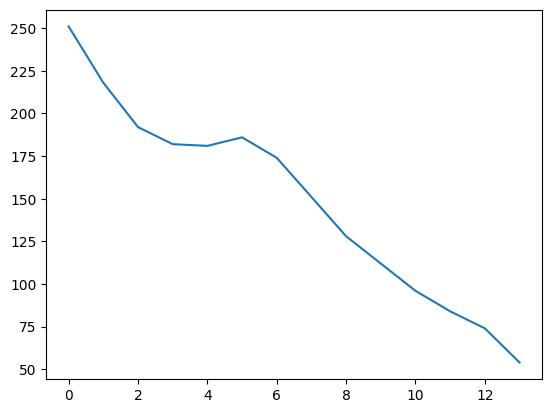

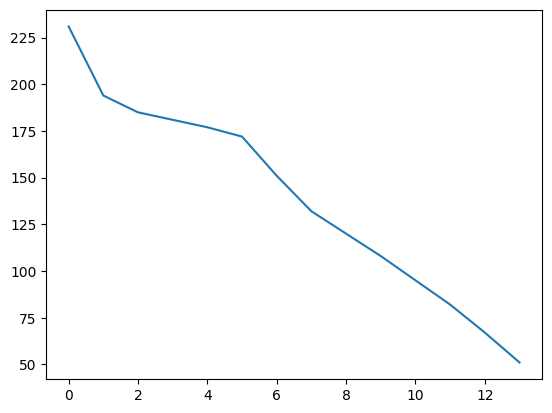

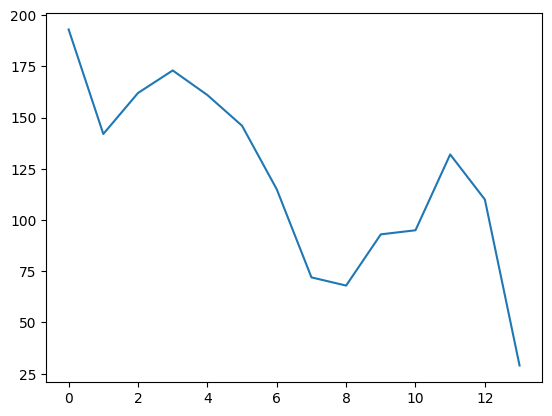

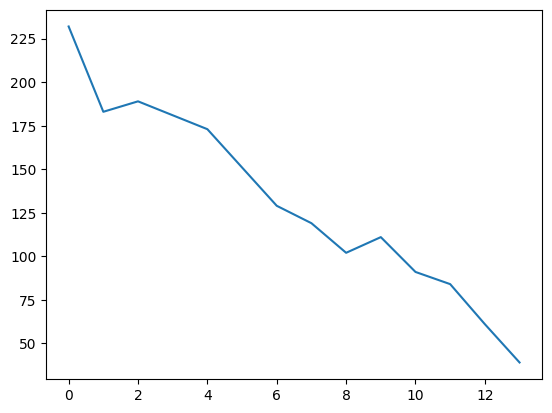

In [5]:
if SITE_NAME == "forearm":
    df1 = get_artery_gcm_metrics(pas[0], plot=[3, 10])
    df2 = get_artery_gcm_metrics(pas[1], plot=[3, 10])

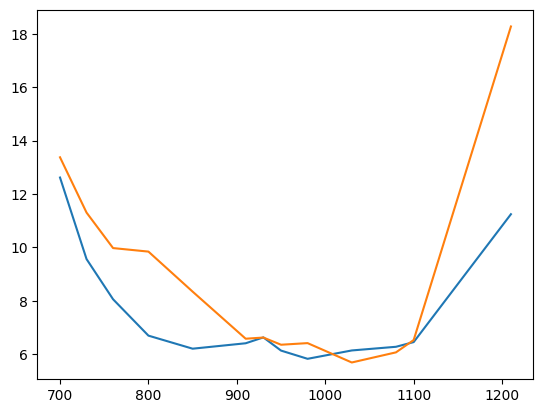

In [6]:
if SITE_NAME == "forearm":
    plt.plot(df1["Wavelength"], df1["dissimilarity"], c="C0")
    plt.plot(df2["Wavelength"], df2["dissimilarity"], c="C1")
# plt.twinx()
# plt.plot(df1["Wavelength"], df1["dissimilarity"].apply(lambda x: x[0,1]), c="C0", linestyle="--")
# plt.plot(df2["Wavelength"], df2["dissimilarity"].apply(lambda x: x[0,1]), c="C1", linestyle="--")

In [7]:
root = data_path
pas = []

In [8]:
results = []
for f in root.glob("**/*.hdf5"):
    pa = pat.PAData.from_hdf5(f)
    pas.append(pa)
    if (
        f"{SITE_NAME}1" not in pa.get_scan_name()
        or ROI_NAME not in pa.get_rois()
        or "parallel" in pa.get_scan_name()
    ):
        continue
    skin_id = f.parent.stem
    r = get_artery_gcm_metrics(pa)
    r["SkinID"] = skin_id
    r["ScanName"] = pa.get_scan_name()
    results.append(r)

In [9]:
df = (
    pd.concat(results)
    .sort_values(by=["SkinID", "ScanName", "Wavelength"])
    .reset_index(drop=True)
)
name = (
    "radial_artery"
    if SITE_NAME == "forearm" and ROI_NAME[0] == "artery_"
    else SITE_NAME + "_" + ROI_NAME[0].split("_")[0]
)
df.to_parquet(f"intermediate data/radiomics_texture_analysis_{name}.parquet")